In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd

In [21]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [23]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine , reflect = True)

In [25]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [26]:
# Save references to each table
measurement_obj = Base.classes.measurement
station_obj = Base.classes.station

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [28]:
''' On exploring the hawaii.sqlite database , we know the last  data point stands at date 2017-08-23'''

# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp_data = session.query(measurement_obj.date , measurement_obj.prcp).\
            filter(measurement_obj.date >= (dt.date(2017 , 8, 23) - dt.timedelta(days = 365))).\
            order_by(measurement_obj.date.desc()).all()

# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017 , 8 ,23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
''' since the query has been already performed, '''

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data , columns = ['Date' , 'Precipitation Score'])
prcp_df.set_index('Date',inplace = True)

# Sort the dataframe by date
prcp_sort = prcp_df.sort_values(by = 'Date',ascending = True)

# check what it looks like
prcp_sort

,Precipitation Score
Date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,NaN
...,...
2017-08-22,0.00
2017-08-23,0.45
2017-08-23,0.08


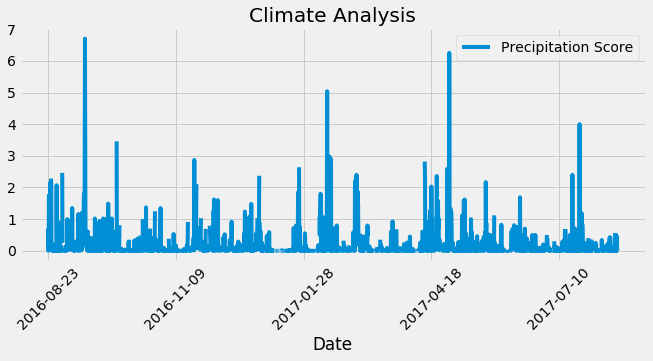

In [29]:
# Use Pandas Plotting with Matplotlib to plot the data   
prcp_plot = prcp_sort.plot(figsize = (10,4),title = 'Climate Analysis', rot = 45)



In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_sort.describe()

,Precipitation Score
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis


In [31]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(measurement_obj,station_obj).\
                 filter(measurement_obj.station == station_obj.station).all()

no_of_stations = []
for record in stations:
    (x,y) = record
    no_of_stations.append(y.station)
    
print(f"There are a total of {len(set(no_of_stations))} stations available in this Dataset.")


There are a total of 9 stations available in this Dataset.


In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?

from collections import Counter
active_stations = Counter(no_of_stations)

# List the stations and the counts in descending order.
most_active_desc = active_stations.most_common()
most_active_desc

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_stats = session.query(func.min(measurement_obj.tobs),func.max(measurement_obj.tobs),\
                              func.avg(measurement_obj.tobs)).filter(measurement_obj.station == most_active_desc[0][0]).all()

print(f"Below are the recorded temperatures for the most active station - {most_active_desc[0][0]} ")
print(f"Lowest Tempeature = {station_stats[0][0]}")
print(f"Highest Temperature = {station_stats[0][1]}")
print(f"Average Temperature = {round(station_stats[0][2],0)}")


Below are the recorded temperatures for the most active station - USC00519281 
Lowest Tempeature = 54.0
Highest Temperature = 85.0
Average Temperature = 72.0


Text(0.5, 0, 'Temperatures')

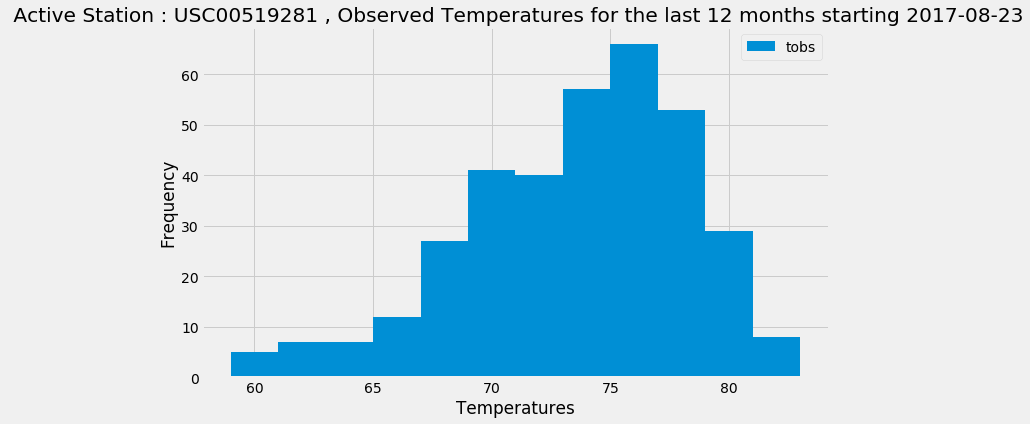

In [58]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
'''Plot the results as a histogram with bins=12.'''

past_twelve = dt.date(2017,8,23) - dt.timedelta(days = 365) 

station_temp = session.query(measurement_obj.tobs).filter(measurement_obj.station == most_active_desc[0][0]).\
               filter(measurement_obj.date >= past_twelve).all()

station_temp_df = pd.DataFrame(station_temp, columns = ['tobs'])
temp_plot = station_temp_df.plot(figsize = (10,6),kind = 'hist',bins = 12)
temp_plot.set_title(f" Active Station : {most_active_desc[0][0]} , Observed Temperatures for the last 12 months starting 2017-08-23")
temp_plot.set_xlabel('Temperatures')

## Bonus Challenge Assignment

In [35]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
